# Gaussian Mixture Model(GMM)
> It is a probabilistic model that assumes data is generated from a mixture of several Gaussian (normal) distributions with unknown parameters. The core idea is to represent complex, multimodal data distributions as a weighted sum of simpler Gaussian components.



Gaussian Mixture Model : 
Suppose that given dataset $X = {x_1, x_2, ..., x_N}$ then GMM assumes that form
$$
p(x) = \sum_{k=1}^K \pi_k , \mathcal{N}(x | \mu_k, \Sigma_k)
$$
where $\pi_k$ is mixing coefficient with $\sum_k \pi_k = 1$, $\mu_k$ is mean of the $k^{th}$ gaussian and $\Sigma_k$ is the covariance of $k^{th}$ gaussian.

Expectation-Maximization (EM) Algorithm is used for estimating the parameters of the GMM.

1. **Initialization**

   * Choose the number of components $K$.
   * Initialize parameters $\pi_k, \mu_k, \Sigma_k$ (randomly or using **k-means**).

2. **E-Step (Expectation)**

   * Compute *responsibilities* (posterior probabilities):
     $$
     r_{ik} = \frac{\pi_k , \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j , \mathcal{N}(x_i | \mu_j, \Sigma_j)}
     $$
   * This represents the probability that data point $x_i$belongs to cluster $k$.

3. **M-Step (Maximization)**

   * Update parameters using the responsibilities:
     $$
     N_k = \sum_i r_{ik}
     $$
     $$
     \pi_k = \frac{N_k}{N}, \quad
     \mu_k = \frac{1}{N_k} \sum_i r_{ik} x_i, \quad
     \Sigma_k = \frac{1}{N_k} \sum_i r_{ik} (x_i - \mu_k)(x_i - \mu_k)^T
     $$

4. **Convergence**

   * Repeat E and M steps until log-likelihood converges:
     $$
     \log p(X | \theta) = \sum_i \log \left( \sum_k \pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \right)
     $$

## Possible Algorithms for estimation of parameters of the GMMs

| Algorithm                 | Type          | Pros                                          | Cons                            |
| ------------------------- | ------------- | --------------------------------------------- | ------------------------------- |
| **EM**                    | Deterministic | Simple, fast convergence                      | Local optima, sensitive to init |
| **Variational Inference** | Bayesian      | Avoids overfitting, automatic model selection | Complex math, slower            |
| **Gibbs Sampling**        | Bayesian      | Uncertainty quantification                    | Computationally expensive       |
| **Online EM**             | Incremental   | Handles large data                            | Approximate updates             |

---

All of the above are implementated into the scikit-learn library
| Library                          | Function                    | Notes                         |
| -------------------------------- | --------------------------- | ----------------------------- |
| `scikit-learn`                   | `GaussianMixture`           | EM-based estimation           |
| `scikit-learn`                   | `BayesianGaussianMixture`   | Variational inference         |
| `PyMC`, `NumPyro`                | Bayesian GMMs               | MCMC or Variational inference |
| `TensorFlow Probability`, `Pyro` | Custom probabilistic models | Flexible and GPU-accelerated  |



In [47]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import tqdm

from src.GaussianMixtureModels import GaussianMixtureModel

### 1. Loading and Overview of dataset

In [29]:
data = pd.read_csv("data/CreditCardClusteringDataset.csv")
data.head(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Understanding Dataset : Each row is a customer record with spending, payment, and credit behavior.
| Column                                                                                  | Meaning                                               |
| --------------------------------------------------------------------------------------- | ----------------------------------------------------- |
| `CUST_ID`                                                                               | Customer ID (unique identifier – drop for clustering) |
| `BALANCE`                                                                               | Average monthly balance                               |
| `BALANCE_FREQUENCY`                                                                     | Frequency of balance updates (0–1)                    |
| `PURCHASES`, `ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`                               | Total purchases and their types                       |
| `CASH_ADVANCE`                                                                          | Amount of cash advance taken                          |
| `PURCHASES_FREQUENCY`, `ONEOFF_PURCHASES_FREQUENCY`, `PURCHASES_INSTALLMENTS_FREQUENCY` | Frequency of purchases                                |
| `CASH_ADVANCE_FREQUENCY`                                                                | Frequency of cash advances                            |
| `CASH_ADVANCE_TRX`, `PURCHASES_TRX`                                                     | Number of transactions                                |
| `CREDIT_LIMIT`                                                                          | Credit limit assigned                                 |
| `PAYMENTS`, `MINIMUM_PAYMENTS`                                                          | Total and minimum payments                            |
| `PRC_FULL_PAYMENT`                                                                      | Fraction of full payments made                        |
| `TENURE`                                                                                | Months of account activity                            |


### 2. Exploratory Analysis of Dataset

In [30]:
df = data
df = df.drop(["CUST_ID"], axis=1)
df.head(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [31]:
total_null = (df.isna()).sum()
total_null

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

There are two columns only that contains the null values 
1. CREDIT_LIMIT contains only 1 null values
2. MINIMUM_PAYMENTS contains total of 313 null values

In [32]:
# to handle the null values within these two columns
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)

/tmp/ipykernel_1382858/3750391768.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
/tmp/ipykernel_1382858/3750391768.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [33]:
# lets recheck
total_null = (df.isna()).sum()
total_null

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [34]:
# 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [35]:
# lets understand descriptive statistics of data by summarize each feature to understand range and variability.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


1. Very large standard deviation - 

<Figure size 2000x2400 with 0 Axes>

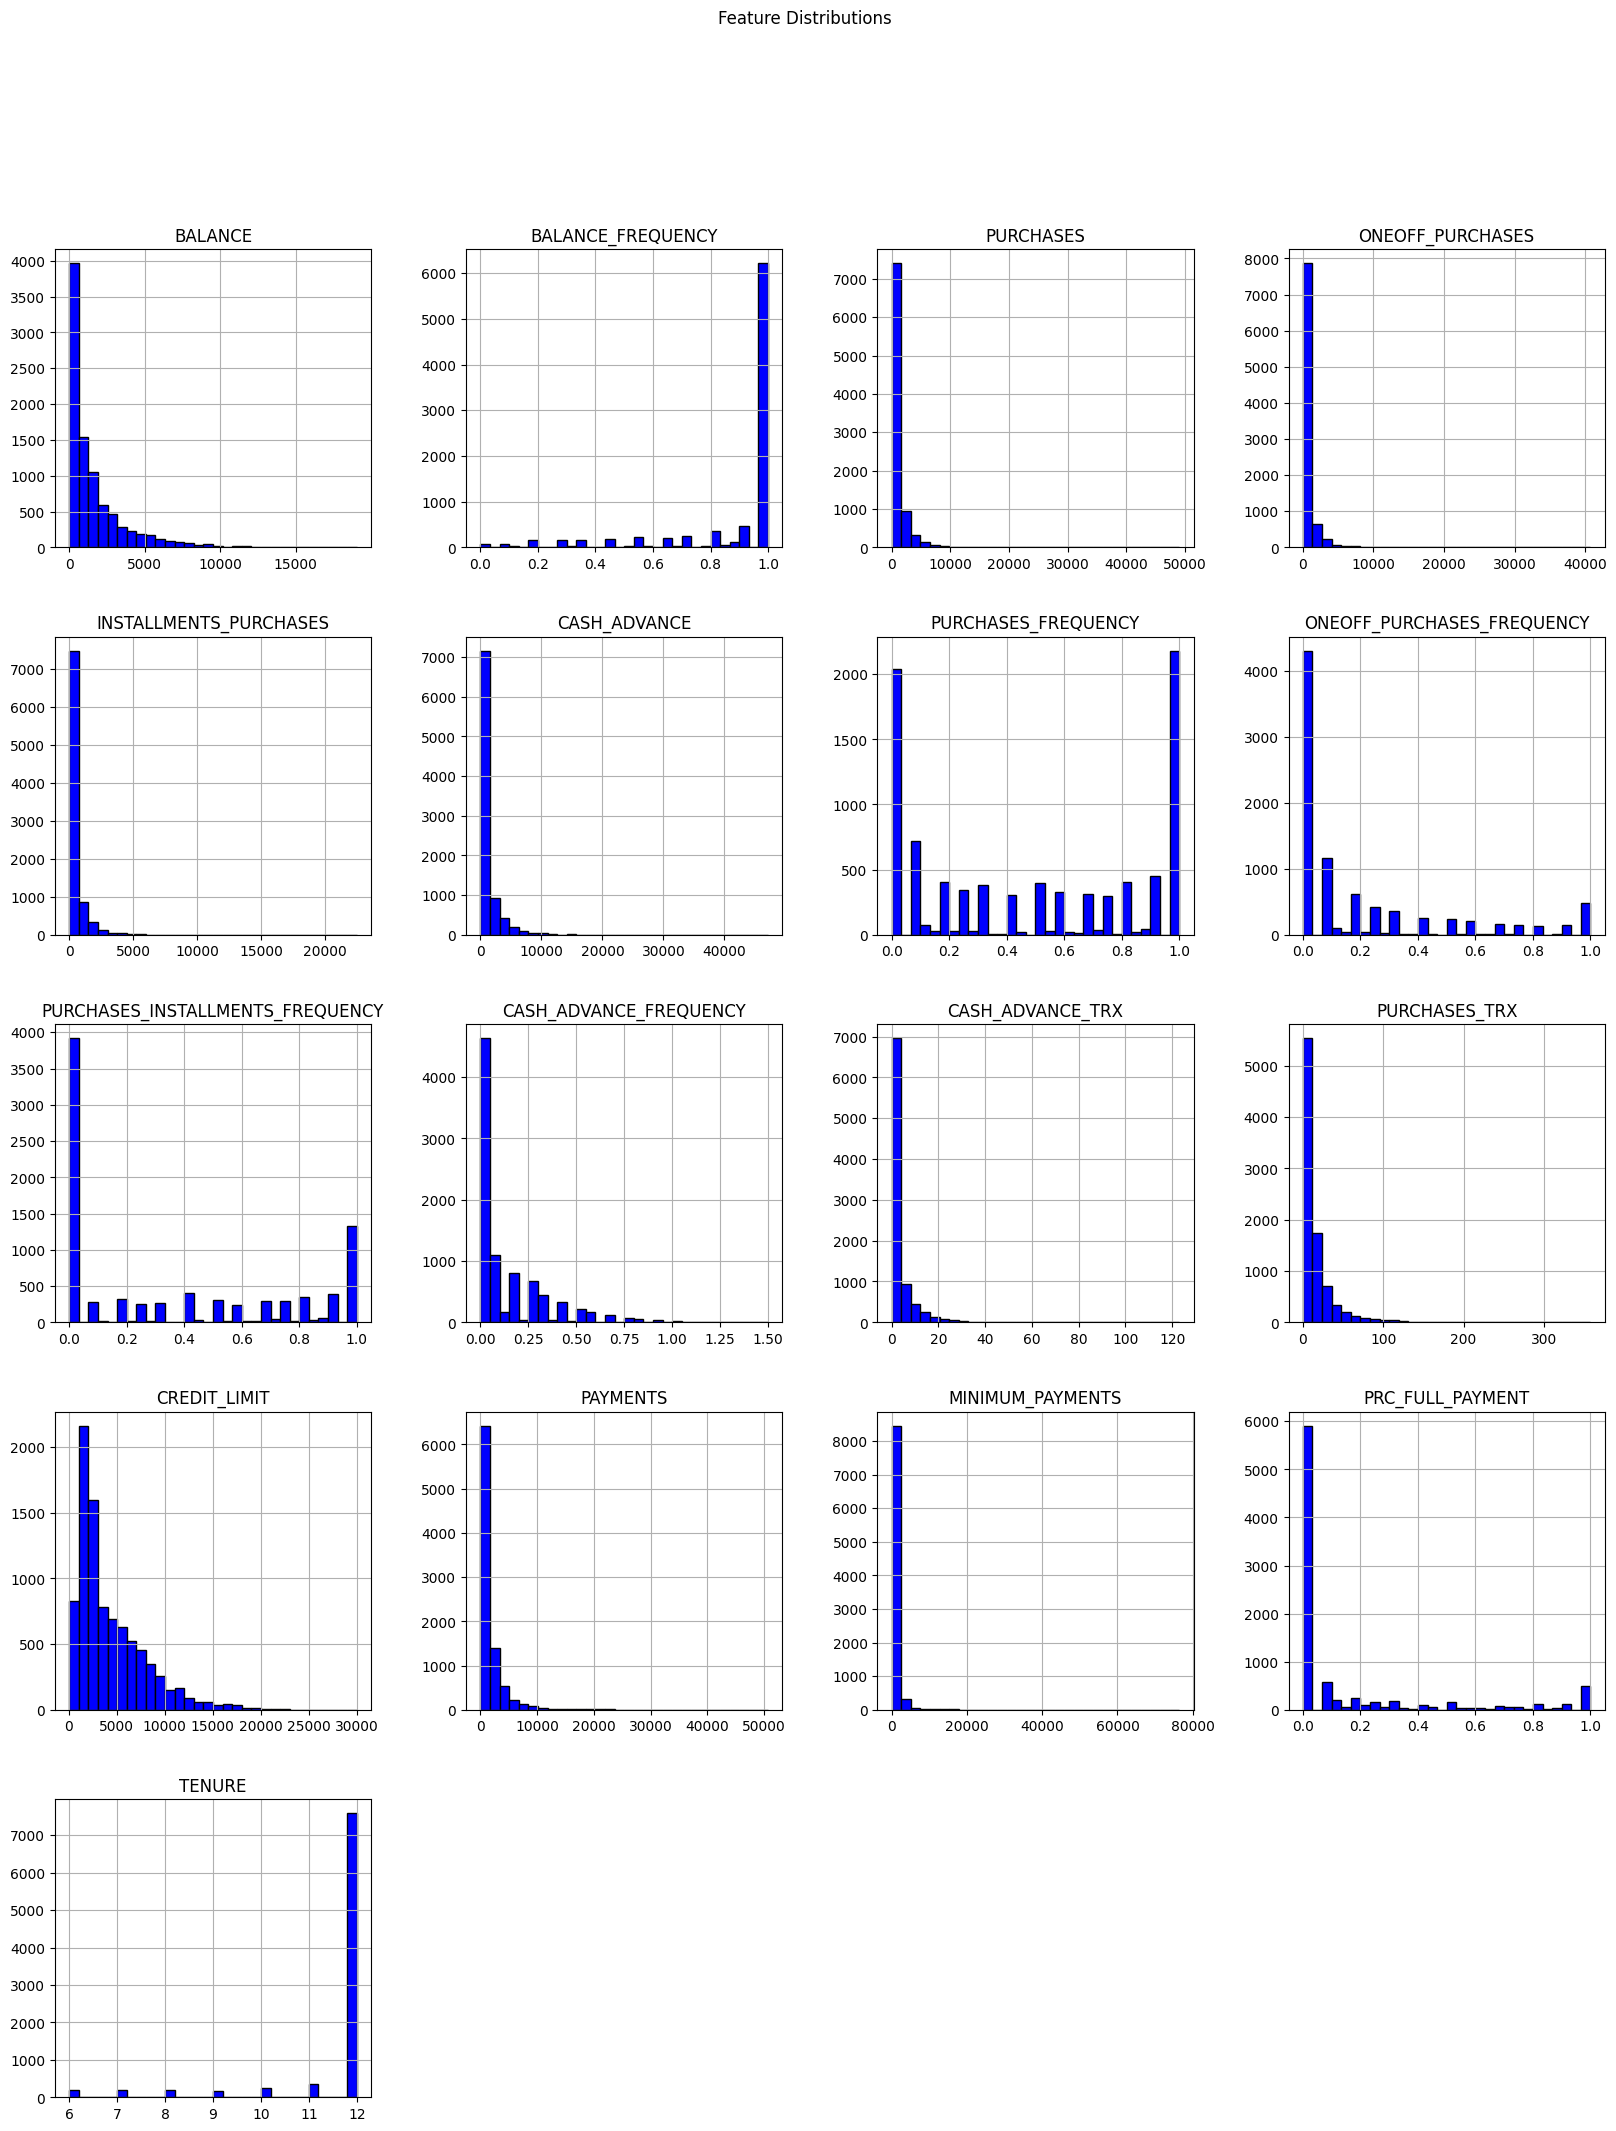

In [36]:
# histogram to visualize how data is distributed
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 24))
df.hist(bins=30, figsize=(20, 24), color='blue', edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()


Are variables skewed? → consider log transform

Are there customers with very high values (outliers)?

<Axes: xlabel='BALANCE', ylabel='Density'>

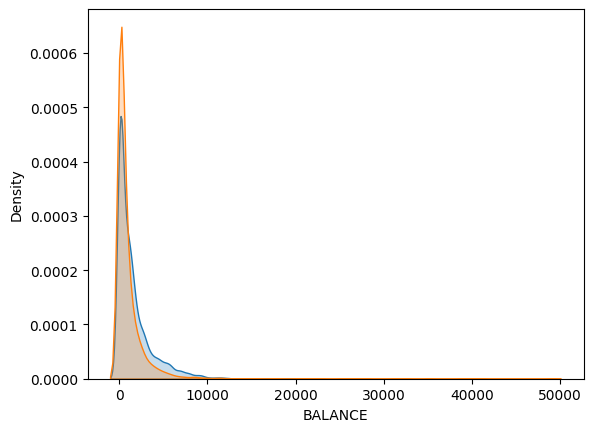

In [12]:
sns.kdeplot(df["BALANCE"], fill=True)
sns.kdeplot(df["PURCHASES"], fill=True)


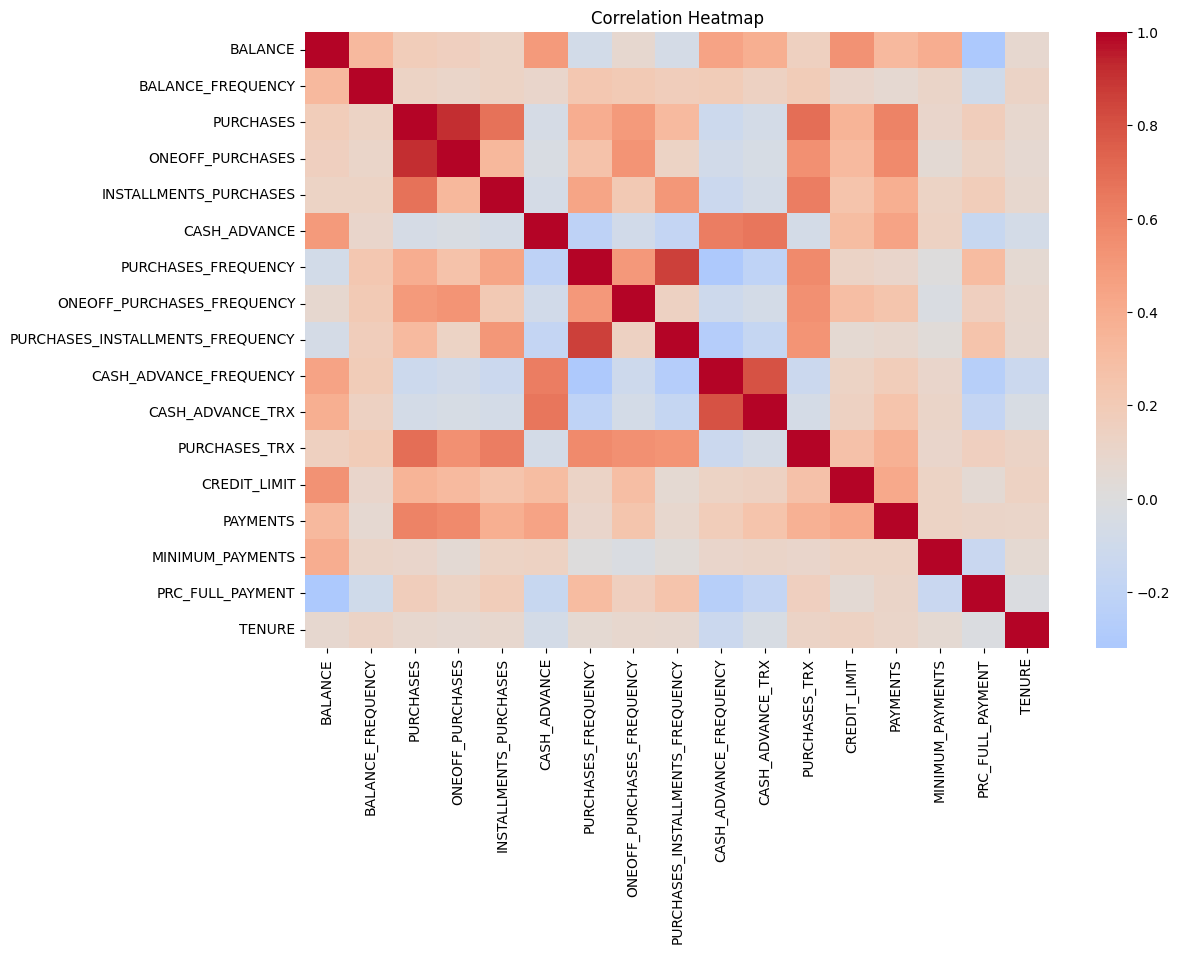

In [13]:
# Find relationships between features.

corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### 3. Preprocessing of Dataset

In [37]:
from sklearn.preprocessing import StandardScaler

X = df.copy()
for col in ['BALANCE','PURCHASES','CASH_ADVANCE','PAYMENTS','MINIMUM_PAYMENTS']:
    X[col] = np.log1p(X[col])

X_scaled = StandardScaler().fit_transform(X)


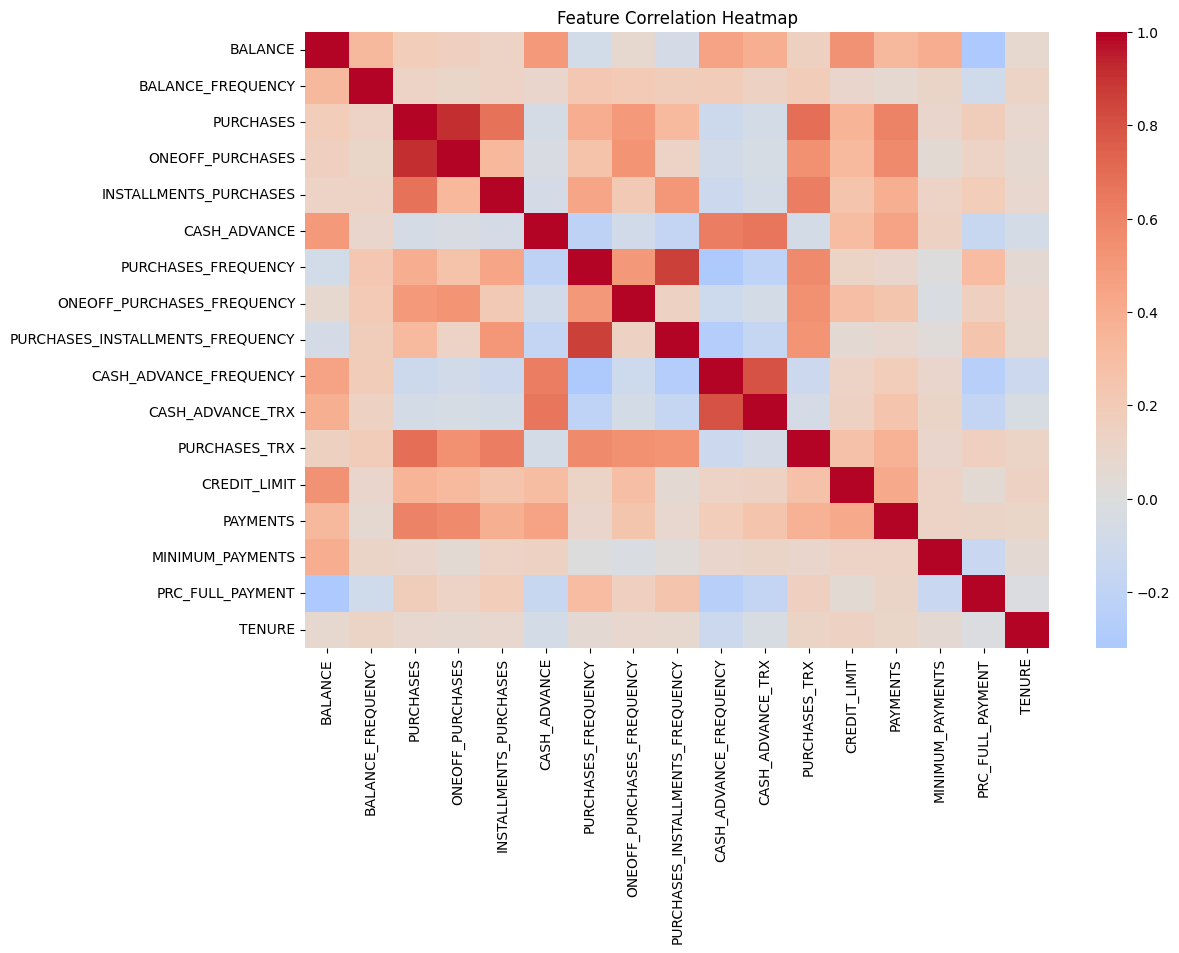

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


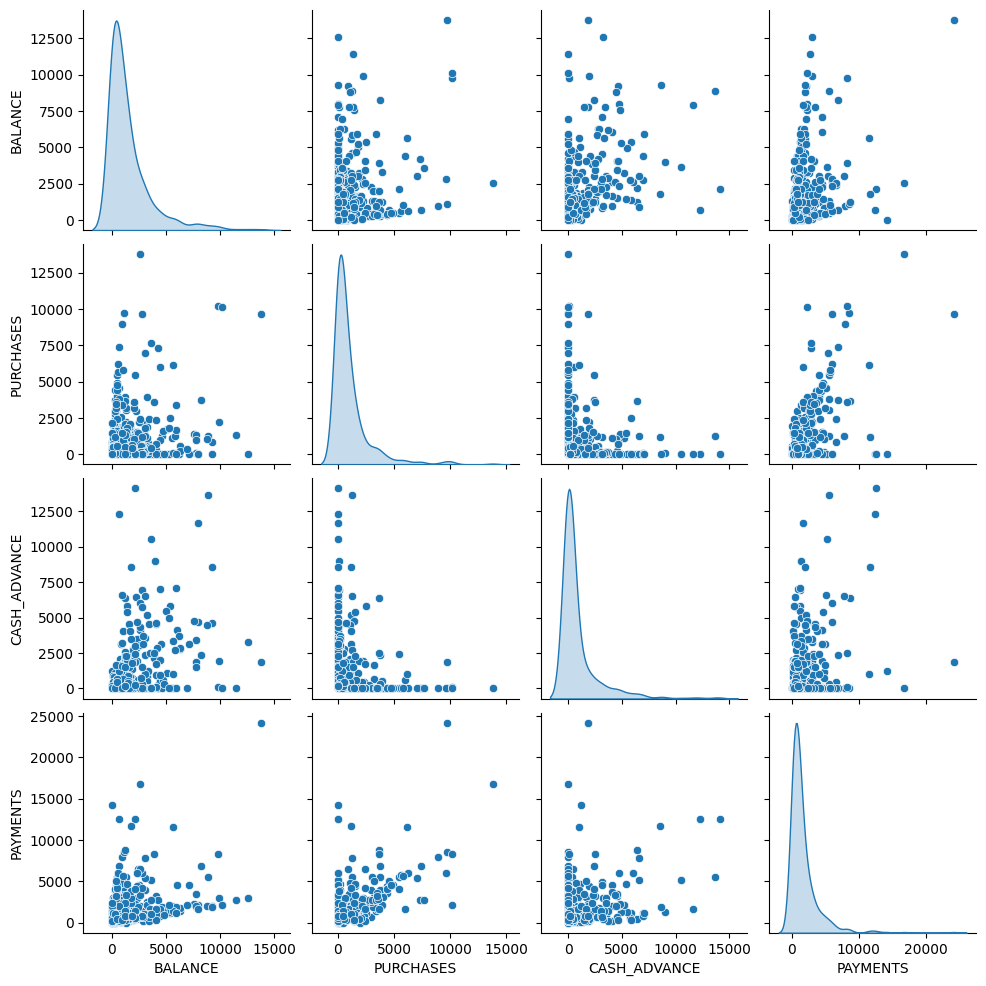

In [16]:
# visualize to find the seperable patterns 
sample_df = df.sample(500, random_state=42)
sns.pairplot(sample_df[['BALANCE','PURCHASES','CASH_ADVANCE','PAYMENTS']], diag_kind='kde')
plt.show()


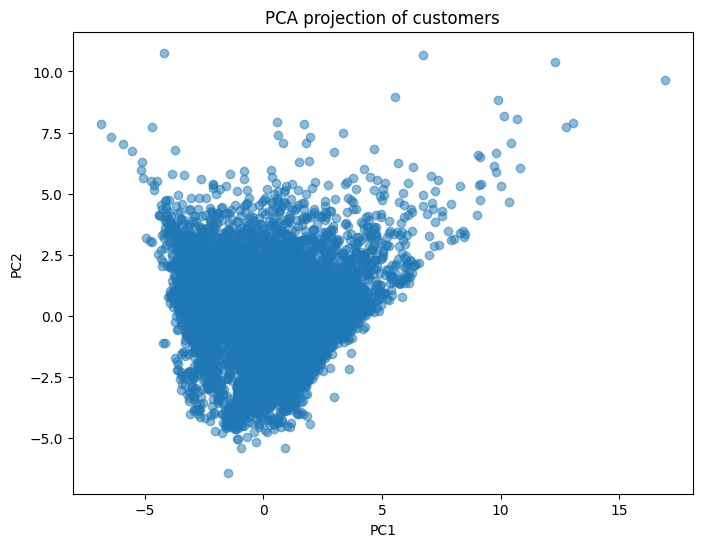

Explained variance ratio: [0.27782179 0.21894436]


In [38]:
# pca for the features analysis
from sklearn.decomposition import PCA 
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA projection of customers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


### 4. Training GMM model

In [39]:
model = GaussianMixtureModel(k=3, X=X_scaled,max_iter=100, tol=1e-4)
model.fit(verbose=True)

# Predict cluster labels
labels = model.predict(X_scaled)
df["Cluster"] = labels

Iteration 1, Log-Likelihood: -147987.0229
Iteration 2, Log-Likelihood: -133948.9091
Iteration 3, Log-Likelihood: -122174.7242
Iteration 4, Log-Likelihood: -101895.9703
Iteration 5, Log-Likelihood: -63806.3192
Iteration 6, Log-Likelihood: -49147.9584
Iteration 7, Log-Likelihood: -42472.1209
Iteration 8, Log-Likelihood: -40218.8948
Iteration 9, Log-Likelihood: -38490.5546
Iteration 10, Log-Likelihood: -37216.3692
Iteration 11, Log-Likelihood: -35750.1973
Iteration 12, Log-Likelihood: -34468.9546
Iteration 13, Log-Likelihood: -33281.3353
Iteration 14, Log-Likelihood: -32190.7315
Iteration 15, Log-Likelihood: -30811.3178
Iteration 16, Log-Likelihood: -28862.7278
Iteration 17, Log-Likelihood: -25960.5655
Iteration 18, Log-Likelihood: -21708.7645
Iteration 19, Log-Likelihood: -10491.6351
Iteration 20, Log-Likelihood: -5955.3191
Iteration 21, Log-Likelihood: 748.9521
Iteration 22, Log-Likelihood: 5119.9542
Iteration 23, Log-Likelihood: 5405.2967
Iteration 24, Log-Likelihood: 6170.4825
Iterati

In [40]:
# total number of clusters
df["Cluster"].nunique()

# total number customers in each clusters
df['Cluster'].value_counts()

Cluster
2    4483
0    2428
1    2039
Name: count, dtype: int64

### 5. Evaluation

In [41]:
# clustering metrices
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette = silhouette_score(X_scaled, labels)
db_index = davies_bouldin_score(X_scaled, labels)

print("Silhouette Score:", silhouette)
print("Davies–Bouldin Index:", db_index)


Silhouette Score: 0.16809991760126752
Davies–Bouldin Index: 2.1212655847208968


Weak cluster separation — the clusters overlap a lot.
Customer behaviors are not clearly distinct in this feature space.
Either the data is inherently continuous (no sharp groups),
or the model’s assumptions (Gaussian ellipsoids) are not ideal.

We can visualize this behaviour with the Feature space visualization

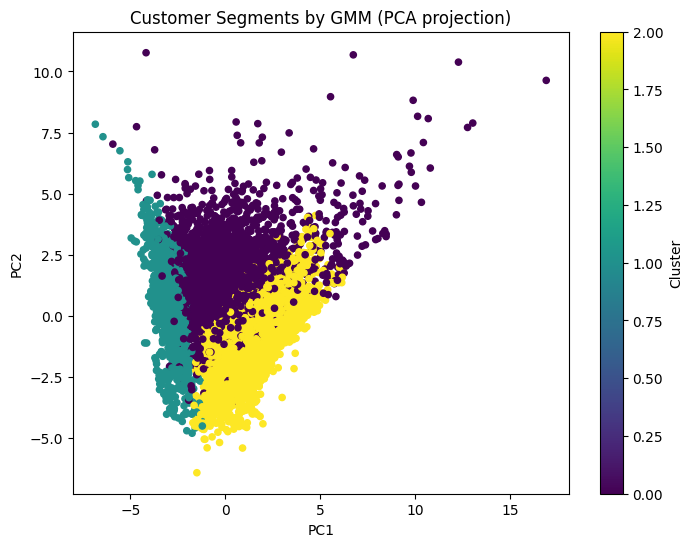

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=20)
plt.title("Customer Segments by GMM (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        2645.360064           0.952496  1773.132253       1137.650482   
1        2150.187407           0.882479     0.000000          0.000000   
2         712.666373           0.834160  1042.497914        566.606982   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                    636.028571   1936.237386             0.596156   
1                      0.000000   1991.030938             0.000000   
2                    476.194078      0.000000             0.656072   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                 
0                          0.299523                          0.421264   
1                          0.000000                        

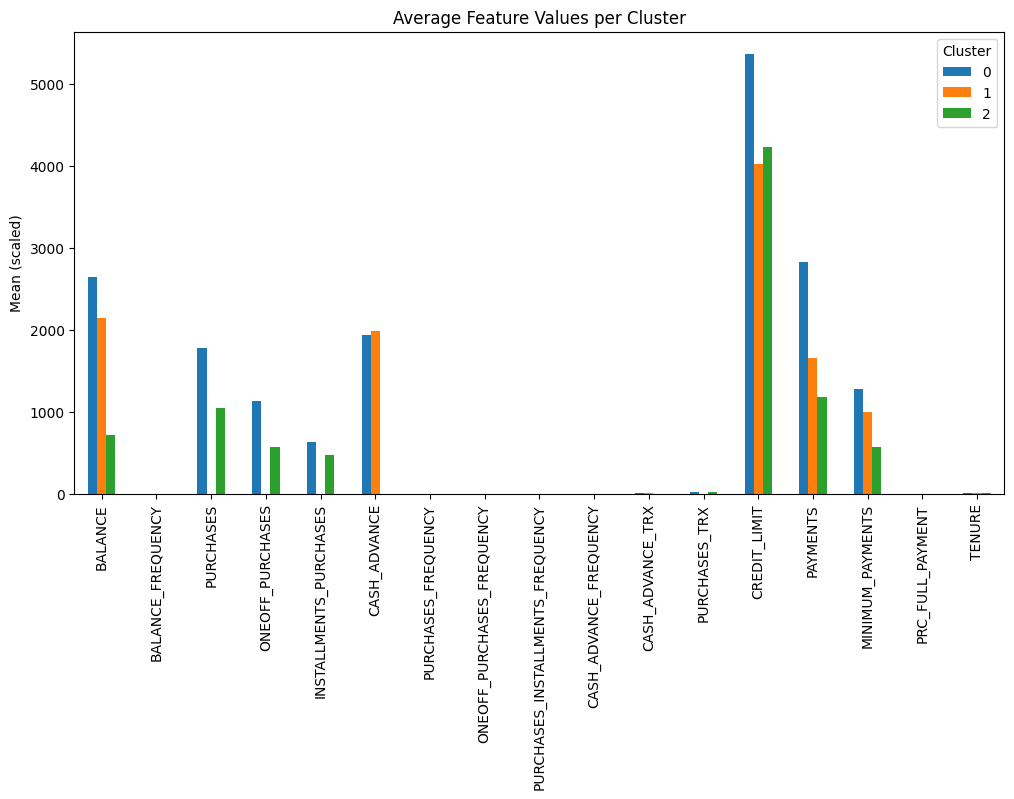

In [43]:
# the avarage behaviour of customers in each clusters
cluster_summary = df.groupby("Cluster").mean()
print(cluster_summary)

# Optionally visualize
cluster_summary.T.plot(kind='bar', figsize=(12,6))
plt.title("Average Feature Values per Cluster")
plt.ylabel("Mean (scaled)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from tqdm import tqdm



num_iterations = 54  # adjust as needed
iterations_data = []

# ----- Run GMM and store parameters at each iteration -----
prev_ll = None
for iteration in tqdm(range(num_iterations)):
    model._e_step()
    model._m_step()
    ll = model._compute_log_likelihood()
    iterations_data.append((model.mu.copy(), model.cov_matrix.copy(), model.pi.copy(), ll))

    if prev_ll is not None and abs(ll - prev_ll) < 1e-6:
        print(f"Converged early at iteration {iteration+1}")
        break
    prev_ll = ll


# ----- Animation -----
def animate(frame: int):
    plt.clf()
    mu, covs, pis, ll = iterations_data[frame]

    plt.title(f"GMM Iteration {frame+1} | Log-Likelihood: {ll:.2f}")
    plt.scatter(X[:, 0], X[:, 1], s=10, c='gray', alpha=0.5, label='Data')

    for j in range(model.k):
        mean = mu[j]
        cov = covs[j]

        # Draw covariance ellipse
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(vals)

        ellip = plt.matplotlib.patches.Ellipse(
            xy=mean, width=width, height=height, angle=theta,
            color=f"C{j}", alpha=min(0.4, pis[j] + 0.1), lw=2, fill=True
        )
        plt.gca().add_artist(ellip)
        plt.scatter(mean[0], mean[1], c=f"C{j}", marker='x', s=100)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.grid(True)


fig = plt.figure(figsize=(7, 6))
anim = FuncAnimation(fig, animate, frames=len(iterations_data), interval=800, repeat=False)
video = anim.to_html5_video()

display(HTML(video))
plt.close()


TypeError: 'module' object is not callable. Did you mean: 'tqdm.tqdm(...)'?